<a href="https://colab.research.google.com/github/princenishad5471/Projects_Resume_Tnp/blob/main/market_impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Auto-detected systemic events: 8
Price        date         close
Ticker                    ^NSEI
0      2019-09-23  11600.200195
1      2020-03-12   9590.150391
2      2020-04-07   8792.200195
3      2020-04-17   9266.750000
4      2020-05-04   9293.500000


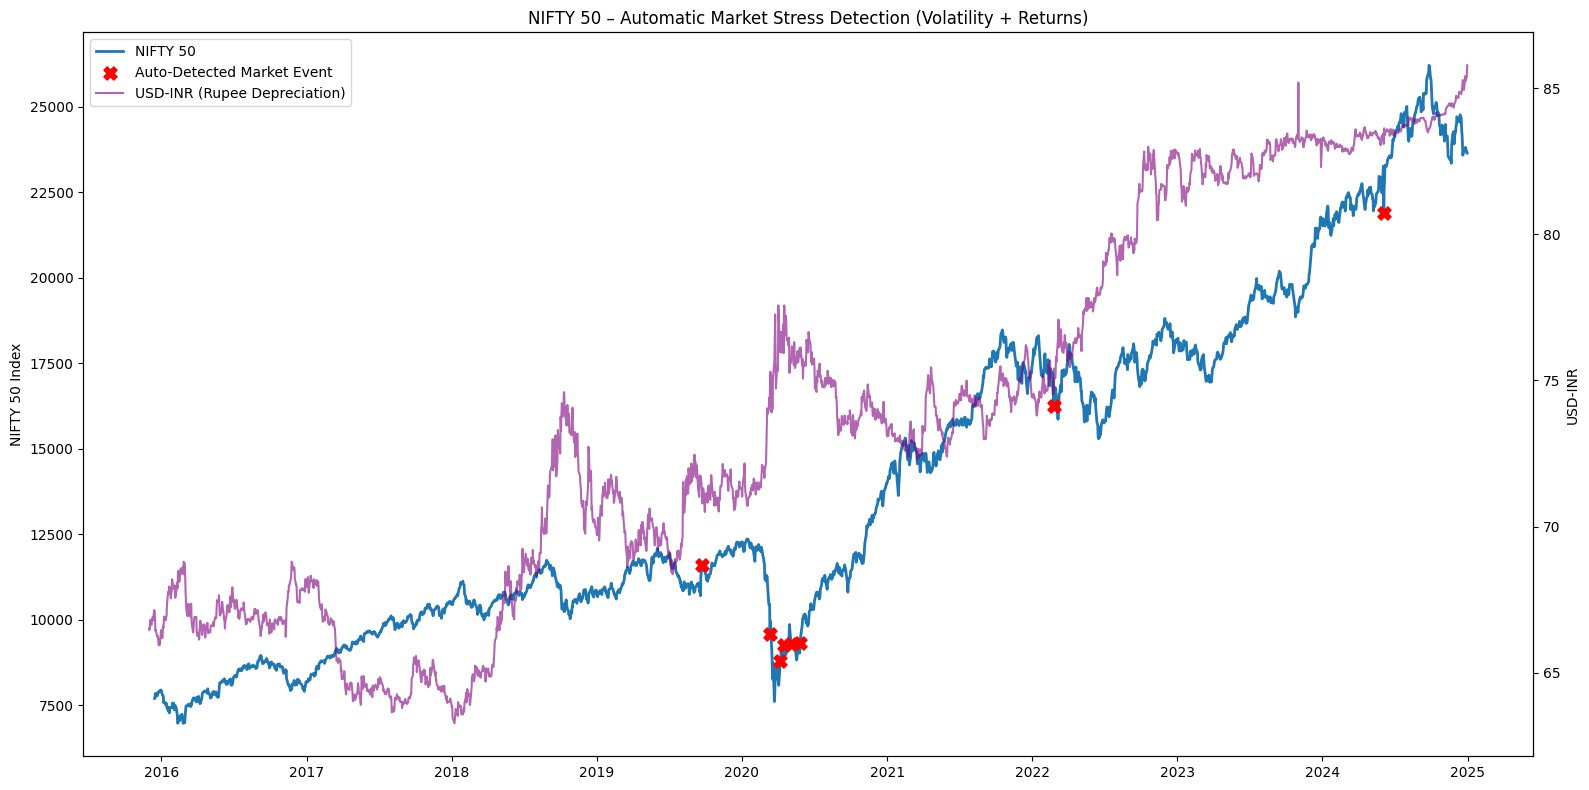

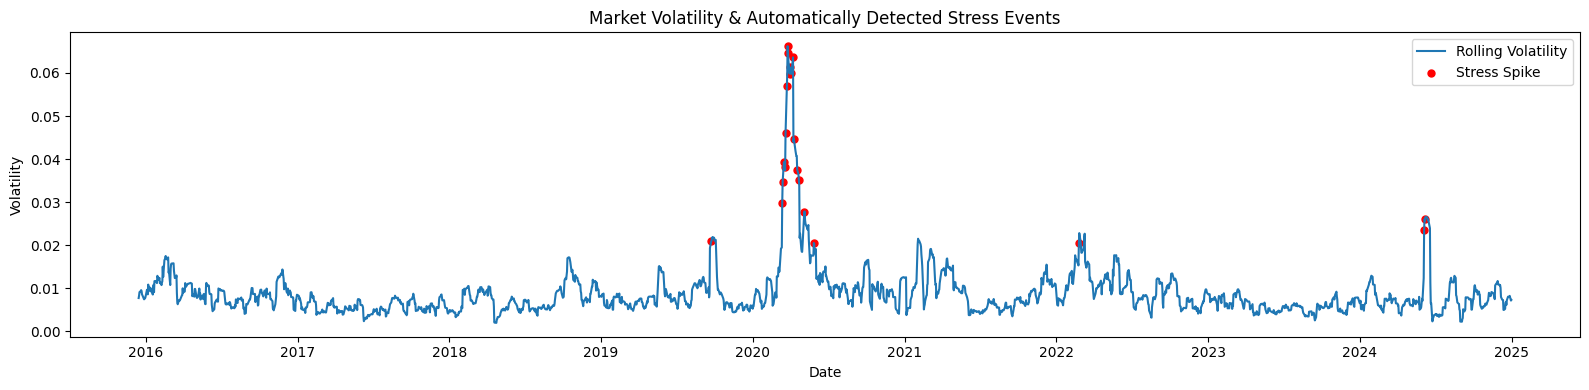

In [1]:
# ======================================================
# NIFTY 50 – AUTOMATIC MARKET EVENT DETECTION & VISUALIZATION
# ======================================================

from __future__ import annotations
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# ======================================================
# Configuration
# ======================================================

@dataclass(frozen=True)
class Config:
    start_date: str = "2015-12-01"
    end_date: str = "2025-01-01"
    vol_window: int = 10
    vol_threshold: float = 2.0
    return_threshold: float = 2.5
    cluster_gap_days: int = 5


CFG = Config()

# ======================================================
# Data Loaders
# ======================================================

def load_nifty_data() -> pd.DataFrame:
    df = yf.download("^NSEI", start=CFG.start_date, end=CFG.end_date, progress=False)
    df.reset_index(inplace=True)
    df.rename(columns={"Date": "date", "Close": "close"}, inplace=True)
    return df[["date", "close"]]


def load_usdinr_data() -> pd.DataFrame:
    df = yf.download("INR=X", start=CFG.start_date, end=CFG.end_date, progress=False)
    df.reset_index(inplace=True)
    df.rename(columns={"Date": "date", "Close": "usdinr"}, inplace=True)
    return df[["date", "usdinr"]]

# ======================================================
# Feature Engineering
# ======================================================

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["return_1d"] = df["close"].pct_change()
    df["rolling_vol"] = df["return_1d"].rolling(CFG.vol_window).std()

    return df.dropna()

# ======================================================
# Automatic Event Detection
# ======================================================

def discover_market_events(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    vol_mean = df["rolling_vol"].mean()
    vol_std = df["rolling_vol"].std()

    ret_mean = df["return_1d"].mean()
    ret_std = df["return_1d"].std()

    df["vol_event"] = df["rolling_vol"] > (vol_mean + CFG.vol_threshold * vol_std)
    df["return_event"] = df["return_1d"].abs() > (ret_mean + CFG.return_threshold * ret_std)

    df["systemic_event"] = df["vol_event"] & df["return_event"]

    return df


def cluster_events(df: pd.DataFrame) -> pd.DataFrame:
    events = df[df["systemic_event"]].copy()

    if events.empty:
        return events

    events["event_group"] = (
        events["date"].diff().dt.days.fillna(0) > CFG.cluster_gap_days
    ).cumsum()

    return events.groupby("event_group").first().reset_index(drop=True)

# ======================================================
# Visualization
# ======================================================

def plot_macro_stress_dashboard(
    nifty: pd.DataFrame,
    usdinr: pd.DataFrame,
    auto_events: pd.DataFrame,
) -> None:
    fig, ax1 = plt.subplots(figsize=(16, 8))

    # NIFTY price
    ax1.plot(nifty["date"], nifty["close"], label="NIFTY 50", linewidth=2)
    ax1.set_ylabel("NIFTY 50 Index")

    # 🔴 Automatic stress events
    if not auto_events.empty:
        ax1.scatter(
            auto_events["date"],
            auto_events["close"],
            color="red",
            s=90,
            marker="X",
            label="Auto-Detected Market Event",
            zorder=5,
        )

    # USD-INR overlay
    ax2 = ax1.twinx()
    ax2.plot(
        usdinr["date"],
        usdinr["usdinr"],
        color="purple",
        alpha=0.6,
        label="USD-INR (Rupee Depreciation)",
    )
    ax2.set_ylabel("USD-INR")

    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.title("NIFTY 50 – Automatic Market Stress Detection (Volatility + Returns)")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


def plot_volatility_timeline(df: pd.DataFrame) -> None:
    plt.figure(figsize=(16, 4))

    plt.plot(df["date"], df["rolling_vol"], label="Rolling Volatility")

    stress = df[df["systemic_event"]]
    plt.scatter(
        stress["date"],
        stress["rolling_vol"],
        color="red",
        s=25,
        label="Stress Spike",
    )

    plt.title("Market Volatility & Automatically Detected Stress Events")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ======================================================
# Main
# ======================================================

def main() -> None:
    nifty = load_nifty_data()
    usdinr = load_usdinr_data()

    nifty = engineer_features(nifty)
    nifty = discover_market_events(nifty)
    auto_events = cluster_events(nifty)

    print(f"Auto-detected systemic events: {len(auto_events)}")
    print(auto_events[["date", "close"]].head())

    plot_macro_stress_dashboard(
        nifty=nifty,
        usdinr=usdinr,
        auto_events=auto_events,
    )

    plot_volatility_timeline(nifty)


if __name__ == "__main__":
    main()
